# Predicting ground states for 2D Heisenberg models

In [1]:
# Basic functionalities
import numpy as np
import random
import copy
import ast
import datetime as dt
from timeit import default_timer as timer
from os import path

# Neural tangent kernel
import jax
from neural_tangents import stax

# Traditional ML methods and techniques
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets
from sklearn import svm
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load data

length = 8 # length = 4, 5, 6, 7, 8, 9 for orig; only 4, 5, 6, 7 for new
width = 5

shadow_size = 500 # up to 1000

Xfull = [] # Shape = (number of data) x (number of params)
Ytrain = [] # Shape = (number of data) x (number of pairs), estimated 2-point correlation functions
Yfull = [] # Shape = (number of data) x (number of pairs), exact 2-point correlation functions

def get_path_prefix(data='orig'):
    prefix = './heisenberg_data/heisenberg_{}x{}'.format(length, width)
    if data == 'new':
        prefix = './new_data/data_{}x{}/simulation_{}x{}'.format(length, width, length, width)
    return prefix
    
data_name = 'orig'
prefix = get_path_prefix(data=data_name)

for idx in range(1, 301):
    if path.exists('{}_id{}_XX.txt'.format(prefix, idx)) == False:
        continue
    with open('{}_id{}_samples.txt'.format(prefix, idx), 'r') as f:
        single_data = []
        classical_shadow_big = [[int(c) for i, c in enumerate(line.split("\t"))] for line in f]
        classical_shadow = classical_shadow_big[0:shadow_size]
        for i in range(length * 5):
            for j in range(length * 5):
                if i == j:
                    single_data.append(1.0)
                    continue
                corr = 0
                cnt = 0
                for shadow in classical_shadow:
                    if shadow[i] // 2 == shadow[j] // 2:
                        corr += 3 if shadow[i] % 2 == shadow[j] % 2 else -3
                    cnt += 1
                single_data.append(corr / cnt)
        Ytrain.append(single_data)
    with open('{}_id{}_XX.txt'.format(prefix, idx), 'r') as f:
        single_data = []
        for line in f:
            for i, c in enumerate(line.split("\t")):
                v = float(c)
                single_data.append(v)
        Yfull.append(single_data)
    with open('{}_id{}_couplings.txt'.format(prefix, idx), 'r') as f:
        single_data = []
        for line in f:
            for i, c in enumerate(line.split("\t")):
                v = float(c)
                single_data.append(v)
        Xfull.append(single_data)

In [3]:
# Print information

Xfull = np.array(Xfull)
print("number of data (N) * number of params (m) =", Xfull.shape)
Ytrain = np.array(Ytrain)
Yfull = np.array(Yfull)
print("number of data (N) * number of pairs =", Yfull.shape)

number of data (N) * number of params (m) = (92, 67)
number of data (N) * number of pairs = (92, 1600)


In [4]:
# Normalize Xfull

xmin = np.amin(Xfull)
xmax = np.amax(Xfull)

# normalize so that all entries are between -1 and 1 using min-max feature scaling
Xfull_norm = np.array(list(map(lambda row : list(map(lambda x : -1 + 2*(x - xmin)/(xmax - xmin), row)), Xfull)))

print(Xfull_norm[0])

[ 1.81919825e-01  5.33921021e-01  1.32691899e-01 -7.96704066e-02
  5.88393286e-01  7.08667985e-01 -5.98811194e-01 -4.02701000e-01
 -5.06283551e-01  1.59568894e-01  2.98026246e-01 -9.78275406e-01
 -8.67210695e-01  9.13937747e-01  2.93643108e-01 -7.75059790e-01
 -4.47900034e-01  3.03592282e-01 -8.86777190e-01  6.85795773e-01
  9.01424407e-01  9.29774910e-01  8.91975816e-01  5.80146972e-01
  6.42677573e-01 -9.31754228e-01 -8.10952383e-01 -3.70068172e-01
 -7.44403339e-01 -2.51514723e-01  8.62647276e-01 -1.21974758e-01
 -5.06232950e-01 -9.76447517e-01 -9.07982281e-01 -7.48397695e-03
  4.64308646e-01 -4.01814261e-01 -1.01482847e-01  7.50578811e-01
 -9.07490317e-01  3.97000462e-01 -2.69674391e-01 -3.94971855e-01
 -2.54738153e-01 -6.98995046e-01 -7.05353677e-01 -4.33135271e-01
 -1.89965630e-01 -7.57992179e-04  3.17897355e-01  3.14437744e-02
 -4.78519868e-01  1.91274078e-01 -4.15009880e-01 -4.22775354e-01
  2.36565108e-01  3.28790405e-01  5.07335903e-01 -9.26304587e-01
  2.87668071e-01 -1.97032

In [5]:
# Categorizing pairs of qubits by distance

# grid of qubits
grid = np.array(range(1, length * width + 1)).reshape((length, width))

# generate all edges in grid in same order as Xfull
all_edges = []
for i in range(0, length):
    for j in range(1, width + 1):
        if i != length - 1:
            all_edges.append((width * i + j, width * (i + 1) + j))
        if j != width:
            all_edges.append((width * i + j, width * i + j + 1))
print(all_edges)
            
def calc_distance(q1, q2):
    # Given two qubits q1, q2 (1-indexed integers) in length x width grid
    # Output l1 distance between q1 and q2 in grid

    pos1 = np.array(np.where(grid == q1)).T[0]
    pos2 = np.array(np.where(grid == q2)).T[0]

    return np.abs(pos1[0] - pos2[0]) + np.abs(pos1[1] - pos2[1])

def get_nearby_qubit_pairs(d):
    # Given distance d > 0
    # Output all pairs of qubits that are within distance d of each other
    
    if d == 1:
        return all_edges
    
    qubit_pairs = []
    for q1 in range(1, length * width + 1):
        for q2 in range(1, length * width + 1):
            dist = calc_distance(q1, q2)
            pair = tuple(sorted((q1, q2)))
            if dist == d and pair not in qubit_pairs:
                qubit_pairs.append(pair)
    
    return qubit_pairs
            

[(1, 6), (1, 2), (2, 7), (2, 3), (3, 8), (3, 4), (4, 9), (4, 5), (5, 10), (6, 11), (6, 7), (7, 12), (7, 8), (8, 13), (8, 9), (9, 14), (9, 10), (10, 15), (11, 16), (11, 12), (12, 17), (12, 13), (13, 18), (13, 14), (14, 19), (14, 15), (15, 20), (16, 21), (16, 17), (17, 22), (17, 18), (18, 23), (18, 19), (19, 24), (19, 20), (20, 25), (21, 26), (21, 22), (22, 27), (22, 23), (23, 28), (23, 24), (24, 29), (24, 25), (25, 30), (26, 31), (26, 27), (27, 32), (27, 28), (28, 33), (28, 29), (29, 34), (29, 30), (30, 35), (31, 36), (31, 32), (32, 37), (32, 33), (33, 38), (33, 34), (34, 39), (34, 35), (35, 40), (36, 37), (37, 38), (38, 39), (39, 40)]


In [6]:
# Finding local patches of a given radius

def get_local_region_qubits(q, delta1):
    # Given a qubit q (1-indexed integer) in length x width grid and radius delta1
    # delta1 = -1 if all qubits are in local region
    # Output list of qubits (1-indexed integers) within a radius of delta1 of q
    
    if delta1 == 0:
        return [q]
    elif delta1 == -1:
        return list(range(1, length * width + 1))
    
    local_qubits = []
    for q2 in range(1, length * width + 1):
        dist = calc_distance(q, q2)
        
        if dist <= delta1:
            local_qubits.append(q2)
    
    return local_qubits

def get_local_region_edges(q1, q2, delta1):
    # Given two qubits q1, q2 (1-indexed integers) in length x width grid and radius delta1
    # delta1 = -1 if all qubits are in local region
    # Output list of tuples of qubits (1-indexed integers) corresponding to edges in local region of radius delta1

    if delta1 == 0:
        return [(q1, q2)]
    elif delta1 == -1:
        return all_edges

    local_qubits = list(set(get_local_region_qubits(q1, delta1) + get_local_region_qubits(q2, delta1)))
    
    local_edges = []
    for edge in all_edges:
        (q1, q2) = edge
        if q1 in local_qubits and q2 in local_qubits:
            local_edges.append(edge)

    return local_edges

def get_local_region_params(q1, q2, delta1, data, i):
    # Given two qubits q1, q2 (1-indexed integers) in length x width grid, radius delta1, and input data (i.e., Xfull)
    # delta1 = -1 if all qubits are considered nearby
    # Output data but only for parameters corresponding to edges within radius delta1
    
    edges = get_local_region_edges(q1, q2, delta1)
    
    indices = [all_edges.index(edge) for edge in edges]
    
    return np.array([data[i][j] for j in sorted(indices)])
    

In [7]:
print('edges: ' + str(get_local_region_edges(1,2,1)))
print('params: ' + str(get_local_region_params(1,2,1, Xfull_norm, 0)))

edges: [(1, 6), (1, 2), (2, 7), (2, 3), (6, 7)]
params: [ 0.18191983  0.53392102  0.1326919  -0.07967041  0.29802625]


In [8]:
# Feature mapping using random Fourier features

def get_feature_vectors(delta1, R, data, omega, gamma=1.0, q1=0, q2=1):
    # Given radius delta1 and hyperparameter R (number of nonlinear features per local region), input data, and fixed randomness omega
    # delta1 = -1 if all qubits are considered nearby
    # Output concatenated feature vectors
    
    # to store all concatenated feature vectors
    all_feature_vectors = []
    
    for i in range(len(data)):
        feature_vector_concat = []
        # iterate over all possible local regions
        n = len(all_edges)
        for k in range(n):
            (q1, q2) = all_edges[k]
            data_local = get_local_region_params(q1, q2, delta1, data, i)
            m_local = len(data_local)

            # do nonlinear feature map on each vector in data_local
            feature_vector = []

            for j in range(R):
                omega_j = omega[k][j]
                val = np.exp(np.dot(omega_j, data_local) * gamma / (m_local ** 0.5) * 1j)
                feature_vector.append(np.real(val))
                feature_vector.append(np.imag(val))

            # concatenate feature vectors together
            feature_vector_concat += feature_vector
            
        all_feature_vectors.append(feature_vector_concat)
        
    # note all_feature_vectors is of size number of data (N) x (2 * R * number of local regions)
    return np.array(all_feature_vectors)
        

In [10]:
# Training and testing algorithm

# set size of local region
delta1 = 0

# set max number of feature entries
max_R = 1000

# set of pairs of qubits we care about predicting correlation function for
for d in [1, 2, 3]:
    qubits = get_nearby_qubit_pairs(d)
    print(qubits)

    # set test size
    test_size = 0.5

    train_idx, test_idx, _, _ = train_test_split(range(len(Xfull)), range(len(Xfull)), test_size=test_size, random_state=0)

    # generate omega to pass into feature mapping
    omega = []
    for (q1, q2) in all_edges:
        m_local = len(get_local_region_edges(q1, q2, delta1))
        omega_sub = []
        for j in range(max_R):
            omega_sub.append(np.random.normal(0, 1, m_local))
        omega.append(omega_sub)

    data_path = './clean_results/new_algorithm/test_size={}_shadow_size={}_d={}'.format(test_size, shadow_size, d)
    with open('{}/results_{}x{}_{}_data.txt'.format(data_path, length, width, data_name), 'w') as f1, open('{}/coefficients_{}x{}_{}_data.txt'.format(data_path, length, width, data_name), 'w') as f2:
        for (q1, q2) in qubits:
            print('(q1, q2) =', (q1, q2))
            print('(q1, q2) =', (q1, q2), file=f1)
            print('(q1, q2) =', (q1, q2), file=f2)

            def train_and_predict():
                # consider the pair (q1, q2)
                global q1, q2

                # training data (estimated from measurement data)
                y = np.array([Ytrain[i].reshape((length * width, length * width))[q1 - 1][q2 - 1] for i in range(len(Xfull))])
                X_train, X_test, y_train, y_test = train_test_split(Xfull_norm, y, test_size=test_size, random_state=0)

                # testing data (exact expectation values)
                y_clean = np.array([Yfull[i].reshape((length * width, length * width))[q1 - 1][q2 - 1] for i in range(len(Xfull))])
                _, _, _, y_test_clean = train_test_split(Xfull_norm, y_clean, test_size=test_size, random_state=0)

                # use cross validation to find the best hyperparameters
                best_cv_score, test_score = 999.0, 999.0
                ML_method = lambda Cx : linear_model.Lasso(alpha=Cx, max_iter=10000)
                best_coef = []
                #ML_method = lambda Cx: KernelRidge(kernel='linear', alpha=Cx)

                for R in [5, 10, 20, 40]:
                    for gamma in [0.4, 0.5, 0.6, 0.65, 0.7, 0.75]:
                        # feature mapping
                        Xfeature_train = get_feature_vectors(delta1, R, X_train, omega, gamma, q1, q2)
                        Xfeature_test = get_feature_vectors(delta1, R, X_test, omega, gamma, q1, q2)

                        for alpha in [2**(-8), 2**(-7), 2**(-6), 2**(-5)]:
                            score = -np.mean(cross_val_score(ML_method(alpha), Xfeature_train, y_train, cv=4, scoring="neg_root_mean_squared_error"))
                            if best_cv_score > score:
                                clf = ML_method(alpha).fit(Xfeature_train, y_train.ravel())
                                test_score = np.linalg.norm(clf.predict(Xfeature_test).ravel() - y_test_clean.ravel()) / (len(y_test) ** 0.5)
                                best_cv_score = score
                                best_coef = clf.coef_.reshape((len(all_edges), 2 * R))

                coef_edges = list(zip(all_edges, np.linalg.norm(best_coef, axis=1)))
                return best_cv_score, test_score, coef_edges

            print(train_and_predict()[0:2], file=f1)
            print(train_and_predict()[2], file=f2)

[(1, 6), (1, 2), (2, 7), (2, 3), (3, 8), (3, 4), (4, 9), (4, 5), (5, 10), (6, 11), (6, 7), (7, 12), (7, 8), (8, 13), (8, 9), (9, 14), (9, 10), (10, 15), (11, 16), (11, 12), (12, 17), (12, 13), (13, 18), (13, 14), (14, 19), (14, 15), (15, 20), (16, 21), (16, 17), (17, 22), (17, 18), (18, 23), (18, 19), (19, 24), (19, 20), (20, 25), (21, 26), (21, 22), (22, 27), (22, 23), (23, 28), (23, 24), (24, 29), (24, 25), (25, 30), (26, 31), (26, 27), (27, 32), (27, 28), (28, 33), (28, 29), (29, 34), (29, 30), (30, 35), (31, 36), (31, 32), (32, 37), (32, 33), (33, 38), (33, 34), (34, 39), (34, 35), (35, 40), (36, 37), (37, 38), (38, 39), (39, 40)]
(q1, q2) = (1, 6)
(q1, q2) = (1, 2)
(q1, q2) = (2, 7)
(q1, q2) = (2, 3)
(q1, q2) = (3, 8)
(q1, q2) = (3, 4)
(q1, q2) = (4, 9)
(q1, q2) = (4, 5)
(q1, q2) = (5, 10)
(q1, q2) = (6, 11)
(q1, q2) = (6, 7)
(q1, q2) = (7, 12)
(q1, q2) = (7, 8)
(q1, q2) = (8, 13)
(q1, q2) = (8, 9)
(q1, q2) = (9, 14)
(q1, q2) = (9, 10)
(q1, q2) = (10, 15)
(q1, q2) = (11, 16)
(q1, 

In [200]:
# Original method from Huang et al, 2022
# Kernel construction

#
# Dirichlet kernel
#

kernel_dir = np.zeros((len(Xfull), Xfull.shape[1]*4))
for i, x1 in enumerate(Xfull):
    cnt = 0
    for k in range(len(x1)):
        kernel_dir[i, cnt] = x1[k]
        cnt += 1
        for k1 in range(-1, 2):
            kernel_dir[i, cnt] = np.cos(np.pi * k1 * x1[k])
            cnt += 1
print("constructed Dirichlet kernel")
            
#
# Neural tangent kernel
#
    
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(1)
)
kernel_NN2 = kernel_fn(Xfull, Xfull, 'ntk')

init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(1)
)
kernel_NN3 = kernel_fn(Xfull, Xfull, 'ntk')
                
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(1)
)
kernel_NN4 = kernel_fn(Xfull, Xfull, 'ntk')

init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(1)
)
kernel_NN5 = kernel_fn(Xfull, Xfull, 'ntk')

list_kernel_NN = [kernel_NN2, kernel_NN3, kernel_NN4, kernel_NN5]

for r in range(len(list_kernel_NN)):
    kernel = list_kernel_NN[r].copy()
    for i in range(len(list_kernel_NN[r])):
        for j in range(len(list_kernel_NN[r])):
            # list_kernel_NN[r][i][j] /= (list_kernel_NN[r][i][i] * list_kernel_NN[r][j][j]) ** 0.5
            list_kernel_NN[r][i].at[j].divide((kernel[i][i] * kernel[j][j]) ** 0.5)
print("constructed neural tangent kernel")
            
#
# RBF kernel is defined in Sklearn
#
print("RBF kernel (will be constructed in sklearn)")


constructed Dirichlet kernel
constructed neural tangent kernel
RBF kernel (will be constructed in sklearn)


In [201]:
# Training and testing algorithm for original method from Huang et al, 2022

# set of pairs of qubits we care about predicting correlation function for
for d in [1, 2, 3]:
    qubits = get_nearby_qubit_pairs(d)

    test_size = 0.5

    train_idx, test_idx, _, _ = train_test_split(range(len(Xfull)), range(len(Xfull)), test_size=test_size, random_state=0)

    with open('./clean_results/orig_algorithm/test_size={}_shadow_size={}_qubits_d={}/results_{}x{}_{}_data.txt'.format(test_size, shadow_size, d, length, width, data_name), 'w') as f:
        for (q1, q2) in qubits:
            # each k corresponds to the correlation function in a pair of qubits
            print("(q1, q2) = ({}, {})".format(q1, q2))
            #print("k =", k, file=f)

            def train_and_predict(kernel, opt="linear"): # opt="linear" or "rbf"

                # instance-wise normalization
                for i in range(len(kernel)):
                    if type(kernel) == np.ndarray:
                        kernel[i] /= np.linalg.norm(kernel[i])
                    else:
                        kernel.at[i].divide(np.linalg.norm(kernel[i]))

                # consider the k-th pair
                global q1, q2

                # training data (estimated from measurement data)
                y = np.array([Ytrain[i].reshape((length * width, length * width))[q1 - 1][q2 - 1] for i in range(len(Xfull))])
                X_train, X_test, y_train, y_test = train_test_split(kernel, y, test_size=test_size, random_state=0)

                # testing data (exact expectation values)
                y_clean = np.array([Yfull[i].reshape((length * width, length * width))[q1 - 1][q2 - 1] for i in range(len(Xfull))])
                _, _, _, y_test_clean = train_test_split(kernel, y_clean, test_size=test_size, random_state=0)

                # use cross validation to find the best method + hyper-param
                best_cv_score, test_score = 999.0, 999.0
                for ML_method in [(lambda Cx: svm.SVR(kernel=opt, C=Cx)), (lambda Cx: KernelRidge(kernel=opt, alpha=1/(2*Cx)))]:
                    for C in [0.0125, 0.025, 0.05, 0.125, 0.25, 0.5, 1.0, 2.0]:
                        score = -np.mean(cross_val_score(ML_method(C), X_train, y_train, cv=5, scoring="neg_root_mean_squared_error"))
                        if best_cv_score > score:
                            clf = ML_method(C).fit(X_train, y_train.ravel())
                            test_score = np.linalg.norm(clf.predict(X_test).ravel() - y_test_clean.ravel()) / (len(y_test) ** 0.5)
                            best_cv_score = score

                return best_cv_score, test_score

            # Dirichlet
            print("Dirich. kernel", train_and_predict(kernel_dir), file=f)
            print("Dirich. kernel", train_and_predict(kernel_dir))
            # RBF
            print("Gaussi. kernel", train_and_predict(Xfull, opt="rbf"), file=f)
            print("Gaussi. kernel", train_and_predict(Xfull, opt="rbf"))
            # Neural tangent
            for kernel_NN in list_kernel_NN:
                print("Neur. T kernel", train_and_predict(kernel_NN), file=f)
                print("Neur. T kernel", train_and_predict(kernel_NN))

(q1, q2) = (4, 5)
Dirich. kernel (0.2524725471445278, 0.24720161876210964)
Gaussi. kernel (0.18580648811215386, 0.19334888028240627)
Neur. T kernel (0.13558781374889525, 0.1640358656018234)
Neur. T kernel (0.1397908436522027, 0.16704989523840308)
Neur. T kernel (0.16193101833276144, 0.18731811705888335)
Neur. T kernel (0.19950551325783114, 0.21130932478677994)


In [1]:
# Post-processing, store all runs in dataframe

import os
import numpy as np
import pandas as pd
import ast
import copy

width = 5
data = []

for data_name in ['orig']:
    length_range = list(range(4, 10))

    for length in length_range:
        for test_size in [0.1, 0.3, 0.5, 0.7, 0.9]:
            for shadow_size in [50, 100, 250, 500, 1000]:
                for d in [1]:
                    # calculate training data size
                    total_data_size = 300
                    if data_name == 'orig' and (length == 4 or length == 5 or length == 7):
                        total_data_size = 100
                    elif data_name == 'orig' and length == 6:
                        total_data_size = 97
                    elif data_name == 'orig' and length == 8:
                        total_data_size = 92
                    elif data_name == 'orig' and length == 9:
                        total_data_size = 89
                    training_size = (1 - test_size) * total_data_size


                    row = ['{}x{}'.format(length, width), d, data_name, training_size, shadow_size, 'Best Previous']
                    # do processing for previous algorithm
                    orig_alg_file = './clean_results/orig_algorithm_processed/test_size={}_shadow_size={}_qubits_d={}/results_{}x{}_{}_data.txt'.format(test_size, shadow_size, d, length, width, data_name)
                    if test_size == 0.5 and shadow_size == 500:
                        for seed in ['4']:
                            new_alg_file = './clean_results/new_algorithm/test_size=0.5_shadow_size=500_d=1_extraruns/results_{}x{}_{}_data{}.txt'.format(length, width, data_name, seed)

                            # do processing for new algorithm
                            row = ['{}x{}'.format(length, width), d, data_name, training_size, shadow_size, 'New']
                            if os.path.exists(new_alg_file):
                                r = open(new_alg_file, 'r')
                                for line in r:
                                    if line[0:3] != '(q1':
                                        row_pair = copy.deepcopy(row)
                                        row_pair.append(ast.literal_eval(line)[1])
                                        data.append(row_pair)
                                        
                        # remove and statement if want all data for previous algorithm
                        if os.path.exists(orig_alg_file) and os.path.exists(new_alg_file):
                            r = open(orig_alg_file, 'r')
                            method_counter = 1
                            for line in r:
                                if line[0:3] != '(q1':
                                    row[-1] = 'Best Previous' + str(method_counter)
                                    row_pair = copy.deepcopy(row)
                                    row_pair.append(ast.literal_eval(line[15:])[1])
                                    if method_counter <= 3: data.append(row_pair)

                                    method_counter += 1
                                    if method_counter > 6:
                                        method_counter = 1

                    else:
                        new_alg_file = './clean_results/new_algorithm/test_size={}_shadow_size={}_qubits_d={}/results_{}x{}_{}_data.txt'.format(test_size, shadow_size, d, length, width, data_name)

                        # remove and statement if want all data for previous algorithm
                        if os.path.exists(orig_alg_file) and os.path.exists(new_alg_file):
                            r = open(orig_alg_file, 'r')
                            method_counter = 1
                            for line in r:
                                if line[0:3] != '(q1':
                                    row[-1] = 'Best Previous' + str(method_counter)
                                    row_pair = copy.deepcopy(row)
                                    row_pair.append(ast.literal_eval(line[15:])[1])
                                    if method_counter <= 3: data.append(row_pair)

                                    method_counter += 1
                                    if method_counter > 6:
                                        method_counter = 1

                        # do processing for new algorithm
                        row = ['{}x{}'.format(length, width), d, data_name, training_size, shadow_size, 'New']
                        new_alg_file = './clean_results/new_algorithm/test_size={}_shadow_size={}_qubits_d={}/results_{}x{}_{}_data.txt'.format(test_size, shadow_size, d, length, width, data_name)
                        if os.path.exists(new_alg_file):
                            r = open(new_alg_file, 'r')
                            for line in r:
                                if line[0:3] != '(q1':
                                    row_pair = copy.deepcopy(row)
                                    row_pair.append(ast.literal_eval(line)[1])
                                    data.append(row_pair)

df = pd.DataFrame(data, columns=['System Size', 'Distance', 'Data Set', 'Training Size', 'Shadow Size', 'Algorithm', 'Avg Prediction Error'])
df.to_excel('./clean_results/results_new.xlsx')

       Unnamed: 0 System Size  Distance Data Set  Training Size  Shadow Size  \
0               0         4x5         1     orig           90.0           50   
1               1         4x5         1     orig           90.0           50   
2               2         4x5         1     orig           90.0           50   
3               3         4x5         1     orig           90.0           50   
4               4         4x5         1     orig           90.0           50   
...           ...         ...       ...      ...            ...          ...   
12543       12543         9x5         1     orig            8.9          500   
12544       12544         9x5         1     orig            8.9          500   
12545       12545         9x5         1     orig            8.9          500   
12546       12546         9x5         1     orig            8.9          500   
12547       12547         9x5         1     orig            8.9          500   

            Algorithm  Avg Prediction E

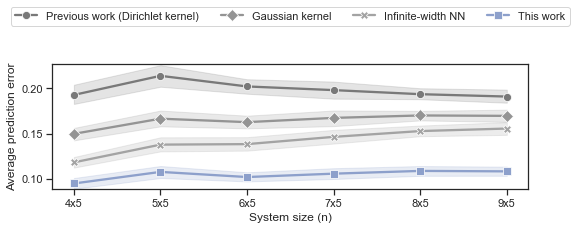

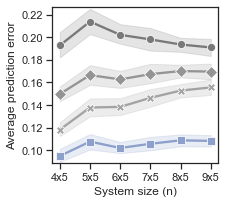

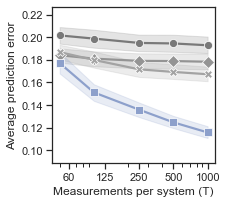

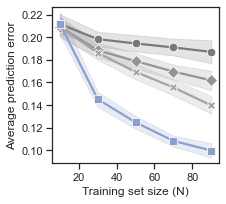

In [2]:
# Plot prediction error

import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import ast
import numpy as np
import os
import pandas as pd
import seaborn as sns

# for plotting prediction error:
sns.set(style="ticks")
df = pd.read_excel('./clean_results_old/results_new.xlsx')

# only using data where we have both previous method and new method data
df = df.dropna()

df['Training Size New'] = (df['Training Size'] // 20) * 20 + 10
print(df[df['Data Set'] == "orig"])

fig=plt.figure(figsize=(8.3, 4.0))

sns.lineplot(
    data=df[(df['Data Set'] == "orig") & (df['Distance'] == 1) & (df['Training Size New'] == 70) & (df['Shadow Size'] == 500)],
    x='System Size',
    y='Avg Prediction Error',
    hue='Algorithm',
    style='Algorithm',
    dashes=False,
    markers=['o', 'D', 'X', 's'],
    markersize=8.1,
    linewidth = 2.3,
    palette=[sns.color_palette("muted")[7], sns.color_palette("colorblind")[7], sns.color_palette("bright")[7], sns.color_palette("Set2")[2]]
)

plt.xlabel('System size (n)')
plt.ylabel('Average prediction error')
plt.xticks(['4x5', '5x5', '6x5', '7x5', '8x5', '9x5'])
plt.ylim(0.0885, 0.227)
plt.legend([],[], frameon=False)
plt.legend(title='', labels=['Previous work (Dirichlet kernel)', 'Gaussian kernel', r'Infinite-width NN', 'This work'], ncol=4, bbox_to_anchor=(0.5, 1.5), loc="upper center")
plt.tight_layout()
plt.savefig('./prediction_error_plots/system-size-for-legend.png', dpi=300)

fig=plt.figure(figsize=(3.3, 3.0))

sns.lineplot(
    data=df[(df['Data Set'] == "orig") & (df['Distance'] == 1) & (df['Training Size New'] == 70) & (df['Shadow Size'] == 500)],
    x='System Size',
    y='Avg Prediction Error',
    hue='Algorithm',
    style='Algorithm',
    dashes=False,
    markers=['o', 'D', 'X', 's'],
    markersize=8.1,
    linewidth = 2.3,
    palette=[sns.color_palette("muted")[7], sns.color_palette("colorblind")[7], sns.color_palette("bright")[7], sns.color_palette("Set2")[2]]
)

plt.xlabel('System size (n)')
plt.ylabel('Average prediction error')
plt.xticks(['4x5', '5x5', '6x5', '7x5', '8x5', '9x5'])
plt.ylim(0.0885, 0.227)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig('./prediction_error_plots/system-size.png', dpi=300)

fig=plt.figure(figsize=(3.3, 3.0))
ax = sns.lineplot(
    data=df[(df['Data Set'] == "orig") & (df['System Size'] == '9x5') & (df['Distance'] == 1) & (df['Training Size New'] == 50)],
    x='Shadow Size',
    y='Avg Prediction Error',
    hue='Algorithm',
    style='Algorithm',
    markers=['o', 'D', 'X', 's'],
    dashes=False,
    markersize=8.1,
    linewidth = 2.2,
    palette=[sns.color_palette("muted")[7], sns.color_palette("colorblind")[7], sns.color_palette("bright")[7], sns.color_palette("Set2")[2]]
)
plt.xlabel(r'Measurements per system (T)')
plt.ylabel('Average prediction error')
plt.xscale('log')
plt.ylim(0.0885, 0.227)
ax.set_xticks([60, 125, 250, 500, 1000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend([],[], frameon=False)
#     plt.legend(title='', labels=['Previous work', 'Gaussian', r'$\infty$-width NN', 'This work'])
plt.tight_layout()
plt.savefig('./prediction_error_plots/shadow-size.png', dpi=300)

fig=plt.figure(figsize=(3.3, 3.0))
sns.lineplot(
    data=df[(df['Data Set'] == "orig") & (df['System Size'] == '9x5') & (df['Distance'] == 1) & (df['Shadow Size'] == 500)],
    x='Training Size New',
    y='Avg Prediction Error',
    hue='Algorithm',
    style='Algorithm',
    markers=['o', 'D', 'X', 's'],
    dashes=False,
    markersize=8.5,
    linewidth = 2.2,
    palette=[sns.color_palette("muted")[7], sns.color_palette("colorblind")[7], sns.color_palette("bright")[7], sns.color_palette("Set2")[2]]
)
plt.xlabel('Training set size (N)')
plt.ylabel('Average prediction error')
plt.ylim(0.0885, 0.227)
plt.legend([],[], frameon=False)
#     plt.legend(title='', labels=['Previous work', 'Gaussian', r'$\infty$-width NN', 'This work'])
plt.tight_layout()
plt.savefig('./prediction_error_plots/training-size.png', dpi=300)


In [4]:
# Code for visualization of ML model

def plot_local_region(length, width, test_size, shadow_size, data_name, d):
    # used to plot coefficients of Lasso for new algorithm on 2D grid to visualize local region found by algorithm

    q1 = 0
    q2 = 0

    f = open('./clean_results_old/new_algorithm/test_size={}_shadow_size={}_qubits_d={}/coefficients_{}x{}_{}_data.txt'.format(test_size, shadow_size, d, length, width, data_name), 'r')
    for line in f:
        if line[0:1] == '(':
            q1, q2 = ast.literal_eval(line[11:-1])
        else:
            edge_and_coef = ast.literal_eval(line)
            coef = np.array(list(map(lambda x : x[1], edge_and_coef)))

            fig=plt.figure(figsize=(3.4*1.01, 3.0*1.01))
            
            G = nx.grid_2d_graph(length, width)

            pos = {(x, y) : (y, -x) for x, y in G.nodes()}
            node_to_int = {}
            for i in range(len(G.nodes())):
                (x, y) = list(G.nodes())[i]
                node_to_int[(x, y)] = i + 1

            edge_cmap = sns.color_palette("light:b", as_cmap=True)
            line_width = coef * 50 + 5
            edge_color = coef * 100
            vmin = min(edge_color)
            vmax = max(edge_color)

            # this is same order as all_edges in algorithm
            edges = list(map(lambda e : (node_to_int[e[0]], node_to_int[e[1]]), list(G.edges())))

            nx.draw_networkx_nodes(
                G,
                pos,
                node_color='#FFFFFF',
                edgecolors='#4B6392',
                linewidths=2.3,
                node_size=500)
            nx.draw_networkx_edges(
                G,
                pos,
                edge_cmap=edge_cmap,
                width=line_width,
                edge_color=edge_color,
                edge_vmin=vmin,
                edge_vmax=vmax)

            nx.draw_networkx_labels(
                G,
                pos,
                labels=node_to_int,
                font_color='#314A7B',
                font_family='avenir',
                verticalalignment='center_baseline')

            # creating colorbar
            sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(vmin=vmin/100, vmax=vmax/100))
            sm._A = []
            plt.colorbar(sm)

            ax = plt.gca()
            ax.set_axis_off()
            ax.margins(0.10)

            plt.title('Visualizing ML for qubits {}, {}'.format(q1, q2), fontname='avenir')
            
            # for other plots
            new_dir = './visualization/local_region_plots/test_size={}_shadow_size={}_{}_data_qubits_d={}_{}x{}'.format(test_size, shadow_size, data_name, d, length, width)
            if not os.path.exists(new_dir):
                os.makedirs(new_dir)
            plt.tight_layout()
            plt.savefig('{}/q1={}_q2={}.png'.format(new_dir, q1, q2), dpi=300)
            plt.clf()
            #plt.show()

    f.close()

# for plotting local region:
length = 5
width = 5
test_size = 0.5
shadow_size = 1000
data_name = 'new'
d = 1
plot_local_region(length, width, test_size, shadow_size, data_name, d)


<ipython-input-4-7edd1da86d56>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(3.4*1.01, 3.0*1.01))


<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>

<Figure size 247.248x218.16 with 0 Axes>